# <p><FONT color=blue>SLIDES INPUT</FONT></p>


## <p><FONT color=blue>README:</FONT></p>

<p><FONT color=blue>The upper part of this notebook contains code and data. Scroll further down for where slides begin.</FONT></p>





## <p><FONT color=blue>PACKAGES</FONT></p>

<p><FONT color=blue>
Standard stuff</FONT></p>


In [65]:
import json
import os
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# spatial stuff
import geopandas as gpd
import fiona
import folium
import shapely

#### <p><FONT color=blue>Extra functions</FONT></p>

<p><FONT color=blue>The function below is taken from https://gist.github.com/pv/8036995</FONT></p>



In [66]:
from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
        
    
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)


<p><FONT color=blue>Making a wrapper function for geopandas</FONT></p>



In [67]:
def voronoi_wrapper(points, origin_geom):
    '''
    Returns a series of Voronoi shapely objects contruced
    from the centroids.
    '''
    
    vor = Voronoi(points)
    
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    def _polygon_intersect(points):
        poly = shapely.geometry.Polygon(points)
        poly_intersect_origin = poly.intersection(origin_geom)
        return poly_intersect_origin
    
    poly_list = [_polygon_intersect(vertices[region]) for region in regions]
    
    return gpd.GeoSeries(poly_list, index=points.index)


<p><FONT color=blue>Function: random voronoi plot</FONT></p>



In [ ]:
from shapely.geometry import box, Point

def random_voronoi_plot(num_points = 6):
    f, ax = plt.subplots(1, 2, figsize=(14, 7))

    coords = pd.DataFrame(np.random.rand(num_points,2))
    gpd.GeoSeries(coords.apply(Point,axis=1)).plot(ax=ax[0])

    vor_gdf = gpd.GeoDataFrame(geometry=voronoi_wrapper(coords, box(0,0,1,1)),
                               data={'label':range(num_points)})
    for i in [0,1]:
        ax[i].set_xlim(0,1)
        ax[i].set_ylim(0,1)

    
    vor_gdf.plot(ax=ax[1], column='label')

Basic plotting stuff

In [ ]:
from shapely.geometry import box

def make_square(lower_left, size): 
    return box(*np.array(lower_left), *(np.array(lower_left)+size))

def shapely_plotter(shapely_object, figsize=(7,7)):    
    gpd.GeoSeries([shapely_object]).plot(figsize=figsize)

## <p><FONT color=blue>DATA AND FIGURES</FONT></p>

#### <p><FONT color=blue> IMPORTANT NOTES</FONT></p>

<p><FONT color=blue>You need to have downloaded the data before starting this script. See the accompanying exercises for instructions.</FONT></p>




#### <p><FONT color=blue>Administrative areas data</FONT></p>


<p><FONT color=blue>We start off by loading adminstrative shape files for parishes and municipalities</FONT></p>


In [68]:
parishes = gpd.read_file('data/SOGN.shp')    
parishes.SOGNEKODE = parishes.SOGNEKODE.astype(int)

municipalities = gpd.read_file('data/KOMMUNE.shp')

# translate column names
municipalities_uk = municipalities.rename(columns={'KOMNAVN':'municipality_name'})[['municipality_name', 'geometry']]
select_cph_frb = municipalities_uk.municipality_name.isin(['København', 'Frederiksberg'])
municipalies_cph = municipalities_uk[select_cph_frb]

<p><FONT color=blue>From the administrative areas we can make unified shapes</FONT></p>




In [159]:
# DK as one shape
denmark_shape = municipalities.unary_union
ex_shape = denmark_shape

# Capital region (without Bornholm) as one shape
cap_reg = municipalities.REGIONNAVN.isin(['Region Hovedstaden'])
non_bornholm = municipalities.bounds.minx<800000

municipalities_select = municipalities[cap_reg & non_bornholm]
cap_region = municipalities_select.unary_union

# Capital region (without Bornholm) as one shape
sealand_reg = municipalities.REGIONNAVN.isin(['Region Hovedstaden', 'Region Sjælland'])
non_bornholm = ~ municipalities.KOMNAVN.isin(['Bornholm', 'Christiansø'])

municipalities_select_sl = municipalities[sealand_reg & non_bornholm]

#### <p><FONT color=blue>Danish house prices from sales data</FONT></p>

<p><FONT color=blue>Note this data is made from Snorre's scraping code.  </FONT></p>

In [70]:
# load data
bolig_path = 'bolig_data.csv'
bolig = pd.read_csv(bolig_path,  low_memory=False, na_values='-')

# structure payment as numeric
bolig.paymentCash = bolig.paymentCash.str.replace('.','').astype(np.float64)

# extract relevant cols and rename
col_dict = {'city_x':'city',
            'mapPosition_latLng_lat':'lat', 
            'mapPosition_latLng_lng':'lon'}

cols_include = ['address', 'buildYear', 'salesPeriodTotal', 'numberOfRooms', 'paymentCash', 'residentialArea', 'areaWeighted', 'postal', 'dateRemoved']
cols_include +=  list(col_dict.keys())

data = bolig[cols_include].rename(columns = col_dict)
data['price_area'] = data.paymentCash / data.areaWeighted
data['price_area_log'] = np.log(data.price_area)

# structure temporal data
data['sale_time'] = pd.to_datetime(data.dateRemoved, format='%d-%m-%Y')
data['sale_year'] = data.sale_time.dt.year

# structure as GeoDataFrame
price_gdf = gpd.GeoDataFrame(data=data, 
                             geometry=data[['lon', 'lat']].apply(shapely.geometry.Point, axis=1),
                             crs={'init':'epsg:4326'})

# change CRS to Danish 32N
price_gdf.to_crs(epsg=25832, inplace=True)

# extract coordinates
price_gdf['e'] = price_gdf.geometry.apply(lambda p: p.x)
price_gdf['n'] = price_gdf.geometry.apply(lambda p: p.y)


# select sealand region
municipalies_cap = municipalities_select_sl.rename(columns={'KOMNAVN':'mun_name'})
price_gdf_cap = gpd.sjoin(price_gdf,municipalies_cap[['geometry', 'mun_name']])


# select subset: year 2010-12 and prices between 1000 and 120000
select_year = price_gdf_cap.sale_year.between(2012,2013)
select_price = price_gdf_cap.price_area.between(1000,120000)

price_gdf_cap_12_13 = price_gdf_cap[select_year & select_price]

if os.path.exists('data/houseprices.GeoJSON'):
    os.remove('data/houseprices.GeoJSON')
price_gdf_cap_12_13.drop('sale_time',1).to_file('data/houseprices.GeoJSON', driver='GeoJSON')


<p><FONT color=blue>World countries as shapes in geodataframe </FONT></p>

In [71]:
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
country_shapes = world_map.geometry

#### <p><FONT color=blue>Youth in Copenhagen  </FONT></p>
<p><FONT color=blue>Use the example DST api and merge with municipal shapes </FONT></p>


In [72]:
dataset_demo = pd.read_csv('danish_parish_demograhic_data.csv')

# define youth variable
dataset_demo['young'] = dataset_demo.age.between(18,30)
c_share = 'Share of young (18-30)'

# count number of young using groupby
young_count = dataset_demo\
                .groupby(['SOGNEKODE', 'year', 'young'])\
                .obs_value.sum()\
                .unstack(level=2)

# extract the count of young for 2010
young_count_10 = young_count\
                    .unstack(level=1)[(True,2010)]\
                    .rename('young_2010')\
                    .reset_index()

# compute share of young in 2008
young_share = young_count[True] / young_count.sum(axis=1)    
young_share_08 = young_share\
                    .unstack(level=1)\
                    [2008]\
                    .rename(c_share)\
                    .reset_index()

# merge data into one                
gdf_parish_young = parishes\
                    .merge(young_share_08)\
                    .merge(young_count_10)
        
# select capital region 
gdf_parish_young_cap_reg = gdf_parish_young[gdf_parish_young.intersects(cap_region)]

<p><FONT color=blue>Select 2012 price sales data and make Voronoi </FONT></p>

In [73]:
# some address coordinates have multiple sales
# we handle this by making a slight perturbation
price_gdf[['e', 'n']] += np.random.normal(scale=100, size=(len(price_gdf), 2))

# select 2012 sales and remove outliers
selection = (price_gdf.sale_year==2012) & \
            (price_gdf.price_area.between(1000,100000))

# make selection, reset_index and copy
prices_12 = price_gdf[selection].reset_index(drop=True).copy()

# make voronoi shapes
voronoi_geom = voronoi_wrapper(prices_12[['e', 'n']], denmark_shape)

# turn into new GeoDataFrame for plotting
prices_12_vor = gpd.GeoDataFrame(data=prices_12,
                                 geometry=voronoi_geom)

<p><FONT color=blue>Building as points</FONT></p>

#### <p><FONT color=blue>Using OpenStreetMaps buildings data</FONT></p>

<p><FONT color=blue>Loading buildings data</FONT></p>



In [74]:
buildings = gpd.read_file('data/gis.osm_buildings_a_free_1.shp')
gs = buildings.geometry.centroid.to_crs({'init': 'epsg:25832'})

<p><FONT color=blue>Selecting some Danish supermarkets</FONT></p>


In [75]:
markets = ['netto', 'brugsen', 'irma', 'fakta', 'føtex', 'kvickly', 'aldi']
build_name = buildings.name.str.lower().fillna('')
selection = pd.concat([build_name.str.contains(m) for m in markets], axis=1).max(axis=1)

build_supermarket = buildings[selection]
build_supermarket_dk_crs = build_supermarket.to_crs(epsg=25832) # change to Danish CRS
geom_sel = build_supermarket.geometry.centroid
geoms = gpd.GeoSeries(geom_sel.values, index=build_supermarket.name)

## <p><FONT color=blue>MAKE FIGURES</FONT></p>

<p><FONT color=blue>Building as points</FONT></p>

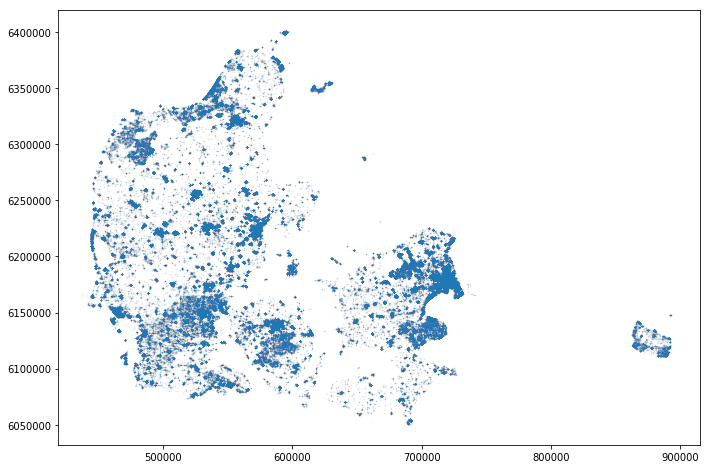

In [76]:
f_build_cluster_point, ax = plt.subplots(figsize=(11.5,8))
gs.plot(markersize=.1, alpha=.05, ax=ax)

<p><FONT color=blue>Plotting supermarkets</FONT></p>

In [77]:
from folium.plugins import MarkerCluster

m_dk_supermarket_cph = folium.Map(location=[55.7, 12.5],
                              tiles='Stamen Toner',
                              zoom_start=10)

marker_cluster_cph = MarkerCluster(
    overlay=True,
    control=False,
    icon_create_function=None)

In [78]:
from folium.plugins import MarkerCluster

m_dk_supermarket = folium.Map(location=[55.7, 12.5],
                              tiles='Stamen Toner',
                              zoom_start=10)

marker_cluster = MarkerCluster(
    overlay=True,
    control=False,
    icon_create_function=None)

for name, point in list(geoms.items()):        
    marker = folium.Marker(location=[point.y, point.x])
    n = name.replace('ø','oe').replace('å','aa').replace('æ','ae').replace("'",'')
    
    popup = n
    folium.Popup(popup).add_to(marker)
    marker_cluster.add_child(marker)
    
marker_cluster.add_to(m_dk_supermarket)

# m_dk_supermarket  

<p><FONT color=blue>Plot: counting young </FONT></p>

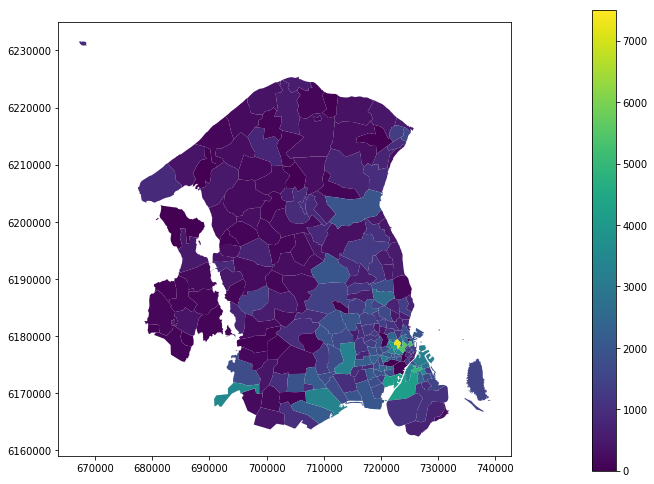

In [79]:
vmin, vmax = 0, 7500
ax = gdf_parish_young_cap_reg\
    .plot(column='young_2010', 
          figsize=(11,8), 
          vmin=vmin, 
          vmax=vmax,
          cmap='viridis')

# add colorbar
f_cph_young_count = ax.get_figure()
cax = f_cph_young_count.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
f_cph_young_count.colorbar(sm, cax=cax)

<p><FONT color=blue>Plot: counting - share young </FONT></p>

/home/andreasbn/miniconda3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


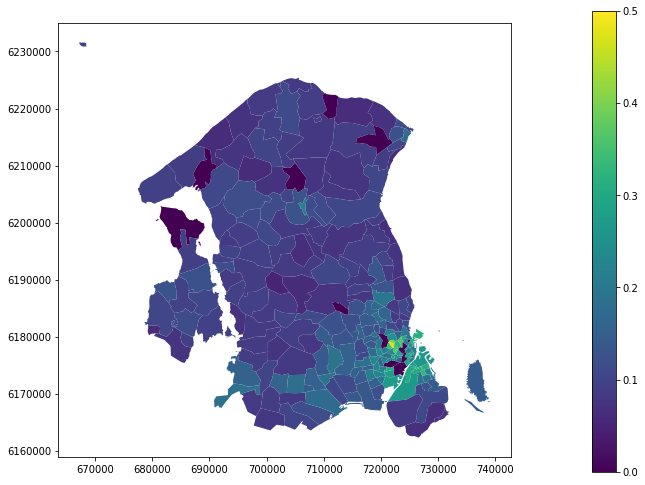

In [80]:
vmin, vmax = 0, .5
ax = gdf_parish_young_cap_reg\
        .plot(column=c_share, 
              figsize=(11,8), 
              vmin=vmin, 
              vmax=vmax,
              cmap='viridis')



# add colorbar
f_cph_young = ax.get_figure()
cax = f_cph_young.add_axes([0.9, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# fake up the array of the scalar mappable. Urgh...
sm._A = []
f_cph_young.colorbar(sm, cax=cax)

<p><FONT color=blue>Voronoi prices</FONT></p>

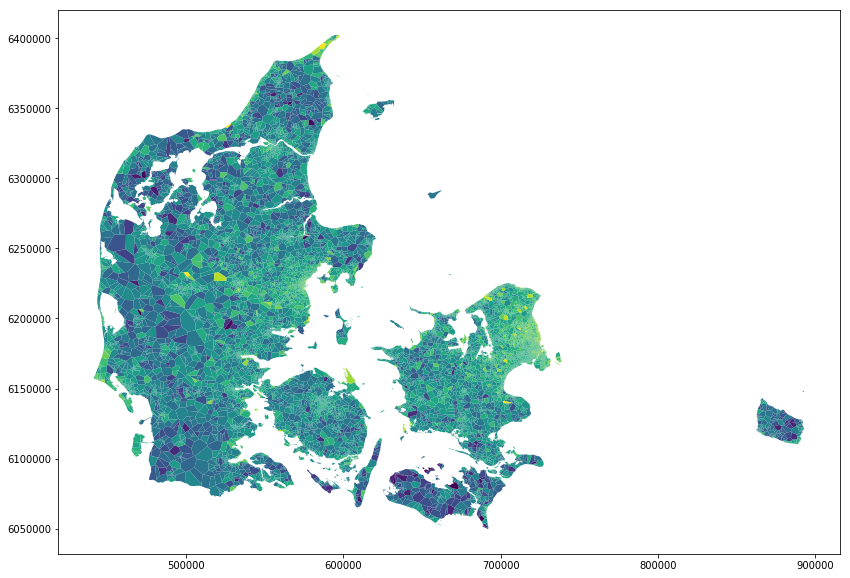

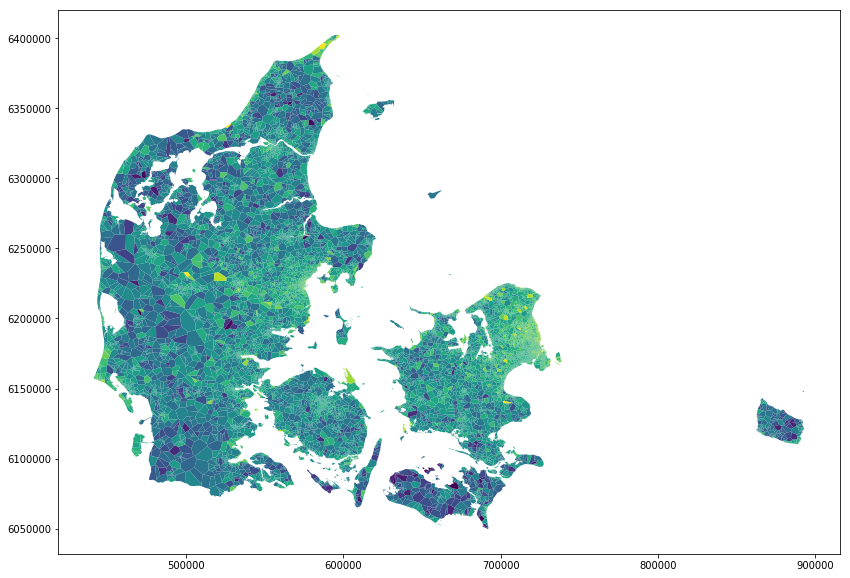

In [99]:
f_price_pointcloud,ax = plt.subplots(figsize=(14,10))
prices_12.plot(column='price_area_log', markersize=4, ax=ax)

f_price_voronoi,ax = plt.subplots(figsize=(14,10))
prices_12_vor.plot(column='price_area_log', ax=ax)

# Spatial data
Manipulation and plotting

*Andreas Bjerre-Nielsen*

# Overview
- Introduction 
- Spatial data 
    - Fundamental concepts and basic procedures
- Working with spatial data
    - Geopandas for data stucturing
    - Folium for interactive plots
- Advanced stuff:
    - Spatial joins
    - Interpolation
- Other: assignments and exam project

# Motivation

## Why spatial data? (1)

Let's try some free public data: 
- Where are the buildings in Denmark? (i.e. where do people live)

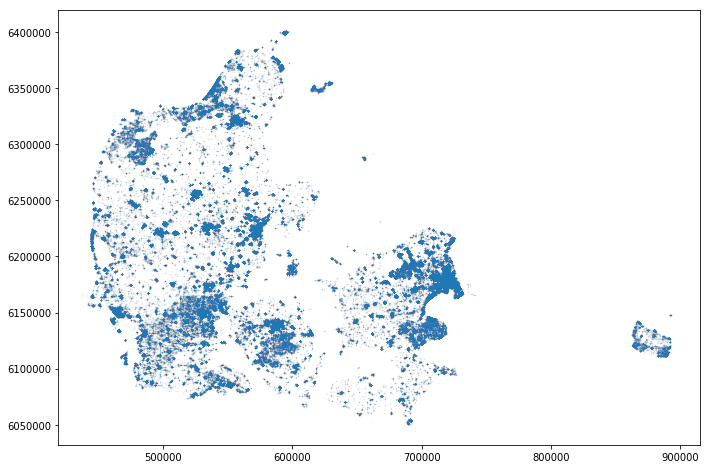

In [82]:
f_build_cluster_point

## Why spatial data? (2)

- Data supply is exploding
    - Free public big data
        - Infrastructure and buildings
        - Weather, housing market, traffic, job openings
        - Other APIs
    - Private big data
        - Smartphone: GPS sensors/wifi
- Spatial proximity > social relation?


## Why spatial data? (3)

- Feature engineering
    - Approximate local measures (interpolation)
    - Intersect behavior and context:
        - Did you visit the supermarket yesterday?
        - Are people who spend more time in greenspace less streesed, less likely to use their phone?
- Identification strategy
    - Spatial RD: use separation administrative boundaries as causal effect
    - Heterogeneous policy responses:

# Core concepts

## What is spatial data? 

- What are spatial objects? Do you know any?

- Spatial objects include classic geometric objects (lines, circles, squares etc.)
- Divided into different generic shapes, examples:
    - Point
    - LineString
    - Polygon (also approximates circles)
    - Multipolygon

## What is spatial data? (2)

Example of a **LineString**

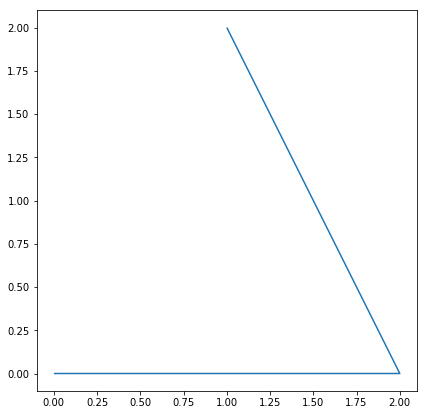

In [115]:
from shapely.geometry import LineString

triangle_coords = np.array([[0,0],[2,0],[1,2]])
linestring = LineString(triangle_coords)

shapely_plotter(linestring)

## What is spatial data? (3)

Example of a **Polygon**

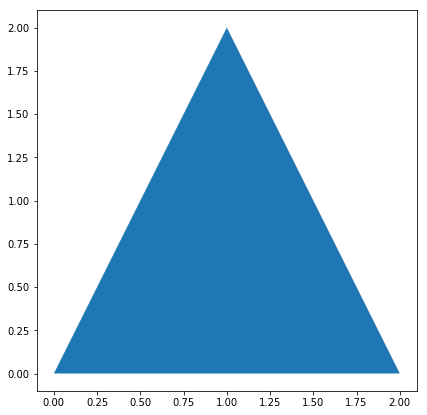

In [140]:
from shapely.geometry import Polygon

triangle_coords = np.array([[0,0],[2,0],[1,2]])
triangle = Polygon(triangle_coords)
shapely_plotter(triangle)

## What is spatial data? (4)

Another example of a **Polygon**

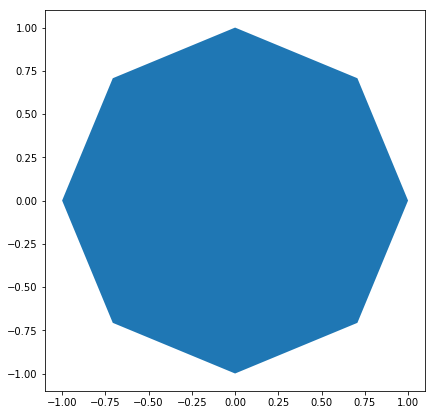

In [203]:
n_points = 8
unit_circle_points = [(np.cos(d),np.sin(d)) for d in np.linspace(0, 2*np.pi, n_points+1)]
unit_circle_poly = Polygon(unit_circle_points)
shapely_plotter(unit_circle_poly)

## What is spatial data? (5)

Example of a **MultiPolygon**

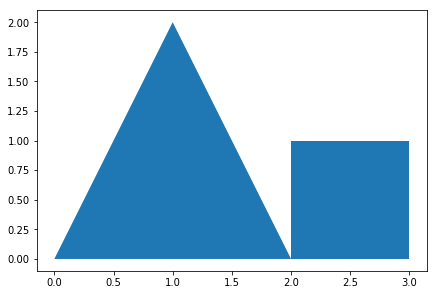

In [239]:
from shapely.geometry import MultiPolygon

multi_poly = MultiPolygon([Polygon(triangle_coords), 
                           Polygon(make_square(lower_left=(2,0), size=1))])

shapely_plotter(multi_poly)

## What is spatial data? (6)

Another example of a **MultiPolygon**

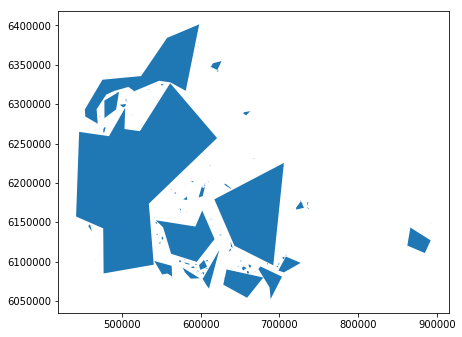

In [176]:
precision_m = 500*100
s = ex_shape.simplify(precision_m)
shapely_plotter(s)

## How do we measure spatial data? 

We need to define the space we work in. What could this be?

- Observations on earth use different Coordinate References System (CRS).

- Differences in CRS: 
    - local CRS are 2d 
    - global CRS:
        - 3d (sphere) 
        - 2d (surface of sphere)

## How do we measure spatial data?  (2)

The standard CRS is:

The system used in Global Positioning System (GPS)
  - Technically called WGS84
  - Has EPSG code 4326 (EPSG: European Petroleum Survey Group, now extinct)
  - 2d surface of sphere

## How do we measure spatial data?  (3)

Working with Danish spatial data you often encounter:

The Danish mapping reference 
  - Technically called ETRS89 UTM Zone 32 North
  - Has EPSG code 25832
  - This is used in Danish admin data.
  - Coordinates measured in meters: can use Euclidian distance

# Spatial operations 

When having two or more spatial objects it is possible to make interactions between them.

Basic operation: distance

- We can measure shortest distance between shapes
- What about spherical surface, e.g. WGS84? (Haversine approximates)

In [267]:
square = make_square(lower_left=(1,0), size=1)

t = Polygon(triangle_coords)
s = Polygon(square)

t.distance(s)

0.0

# Spatial operations (2)

Set like operations ~ make new shapes:
- Intersection (A and B)
- Union (A or B)    
- Difference (A not B)

We can ask whether two shapes 
- Intersect or not
- Touch or not
    


# Spatial operations (3)

Basic 'set-like' operations in `shapely`.

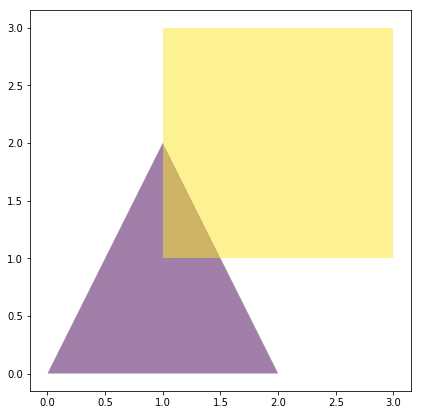

In [268]:
rect_coords = [[0, 0], [0, 2], [1, 2], [1, 0]]

A = Polygon(triangle_coords)
B = Polygon(make_square((1,1), size=2))

gpd.GeoDataFrame(geometry=[A,B],data={'label':[0,1]})\
   .plot(column='label', alpha=.5, figsize=(7,7))

# Spatial operations (4)

Basic 'set-like' operations in `shapely`: union, intersection, difference

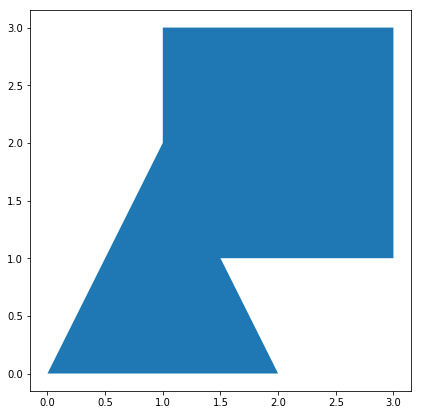

In [252]:
shapely_plotter(A|B) 

# Spatial operations (4)

Other operations
- area: size shape's area
- bounds: max, min of coords
- buffer: layer around shape 
- simplify: reduce precision of shape



# Applied spatial data

## How do we work with spatial data?

GeoPandas: 
- Collection of spatial objects
    - Powerful data structuring 
    - Static plots
- Combines
    - Pandas (labelled arrays and methods)
    - Shapely (Python shape objects)
    - Fiona (low level, ultra fast for complex operations)

Folium
- Interactive plots: map overlay for OpenStreetMaps and zoom

## How do we work with spatial data? (2)

Let's install those packages:

`conda install -c conda-forge geopandas folium -y`

# Spatial Data Structures

## Spatial shapes

We have already seen how to employ `shapely` to construct spatial shapes.

What if we have more than one spatial object?

We could store spatial objects in lists but that is not smart. Why?

## GeoSeries
A smart container for spatial data is the GeoSeries:
- 1d array with labels (like Pandas series) 
- useful spatial tools

In [87]:
country_shapes.head(3)

0    POLYGON ((61.21081709172574 35.65007233330923,...
1    (POLYGON ((16.32652835456705 -5.87747039146621...
2    POLYGON ((20.59024743010491 41.85540416113361,...
Name: geometry, dtype: object

## GeoDataFrame

There is also the GeoDataFrame which has a dedicated column for geometry:

In [264]:
world_map.head(10) #.shape

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...
5,2967004.0,Asia,Armenia,ARM,18770.0,"POLYGON ((43.58274580259273 41.09214325618257,..."
6,3802.0,Antarctica,Antarctica,ATA,760.4,(POLYGON ((-59.57209469261153 -80.040178725096...
7,140.0,Seven seas (open ocean),Fr. S. Antarctic Lands,ATF,16.0,"POLYGON ((68.935 -48.62500000000001, 69.58 -48..."
8,21262641.0,Oceania,Australia,AUS,800200.0,(POLYGON ((145.3979781434948 -40.7925485166058...
9,8210281.0,Europe,Austria,AUT,329500.0,"POLYGON ((16.97966678230404 48.12349701597631,..."


# Map making

## Static plots

Let's try to plot the world's countries. Easy as hell with GeoPandas:

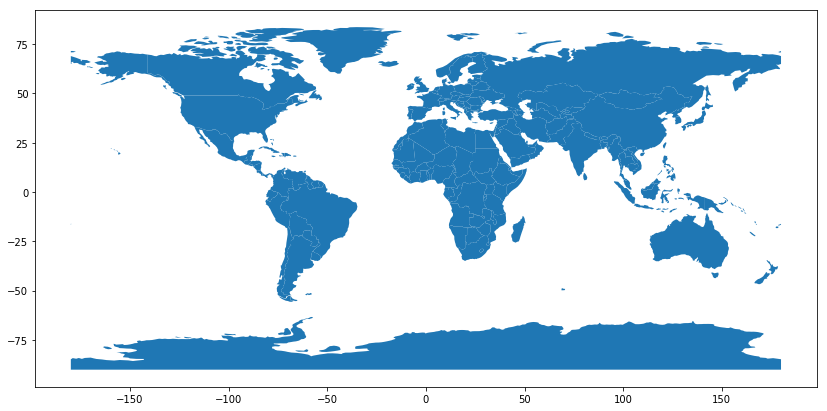

In [89]:
world_map.plot(figsize=(14,7))

## Static plots (2)

Now let's try to plot the share of young around in the Capital Region of Denmark (excluding Bornholm):

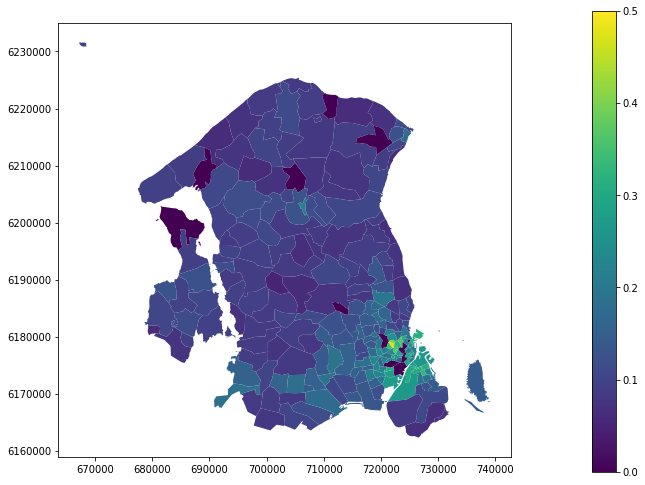

In [90]:
f_cph_young

## Static plots (3)

Never plot sum or count !!! !

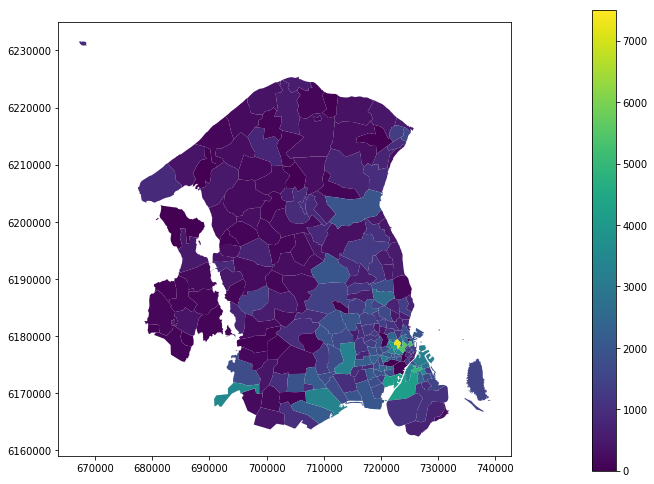

In [91]:
f_cph_young_count

## Plots with interaction

Make a map of many points for Danish supermarkets (exercises)

In [92]:
m_dk_supermarket

# Vectorized spatial operations
 
Example of spatial join through intersection with `GeoPandas`' `sjoin`.

In [94]:
supermarket_cph = gpd.sjoin(build_supermarket_dk_crs, municipalies_cph)
supermarket_cph.head()

,osm_id,code,fclass,name,type,geometry,index_right,municipality_name
3564,38758338,1500,building,Føtex,retail,"POLYGON ((727508.8126623534 6172075.677844482,...",218,København
3565,38758339,1500,building,Kvickly,retail,"POLYGON ((727502.6523104461 6172173.83351121, ...",218,København
12902,91794874,1500,building,Netto,None,"POLYGON ((725871.8909838663 6171720.351222028,...",218,København
140765,107100656,1500,building,Netto,None,"POLYGON ((726482.9790825507 6176113.889892754,...",218,København
188112,143436021,1500,building,Kvickly Sundby,None,"POLYGON ((726647.1852583011 6173745.766217454,...",218,København


# Vectorized spatial operations (2)

Check output of spatial join

In [95]:
centroid = supermarket_cph.centroid.to_crs(epsg=4326)
for lat,lon in zip(centroid.y, centroid.x):
    marker_cluster_cph.add_child(folium.Marker(location=[lat, lon]))
marker_cluster_cph.add_to(m_dk_supermarket_cph)
m_dk_supermarket_cph

# Vectorized spatial operations (3)

Why is this relevant?

- What is the space people are exposed to?
- Context matters for everything
    - Whole field in psychology devoted to this
    - Model features (OpenStreetMaps, Streetviews)

# Storing spatial data

There are two standard formats:
- GeoJSON (.GeoJSON):
    - This is getting more common, especially in more modern applications.
- Shapefiles (.shp)
    - The de-facto standard format. This is a collection of files where the central one is the `.shp` file.

# Spatial interpolation

## What is spatial interpolation? 

What is the simplest possible spatial interpolation pattern?

- The nearest neighbor?

- The nearest neighbor plot is known a the Voronoi plot

## What is spatial interpolation? (2)

Let's see what a Voronoi plot looks like

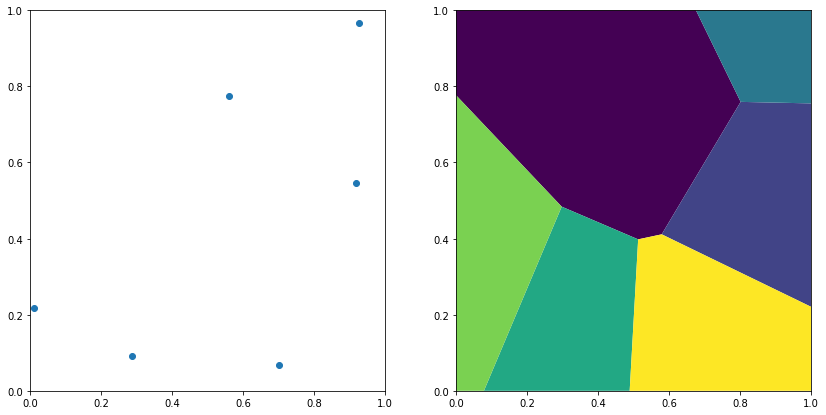

In [270]:
random_voronoi_plot()

## What is spatial interpolation? (3)

Let's plot 2012 house sale prices. Coverage in rural regions?

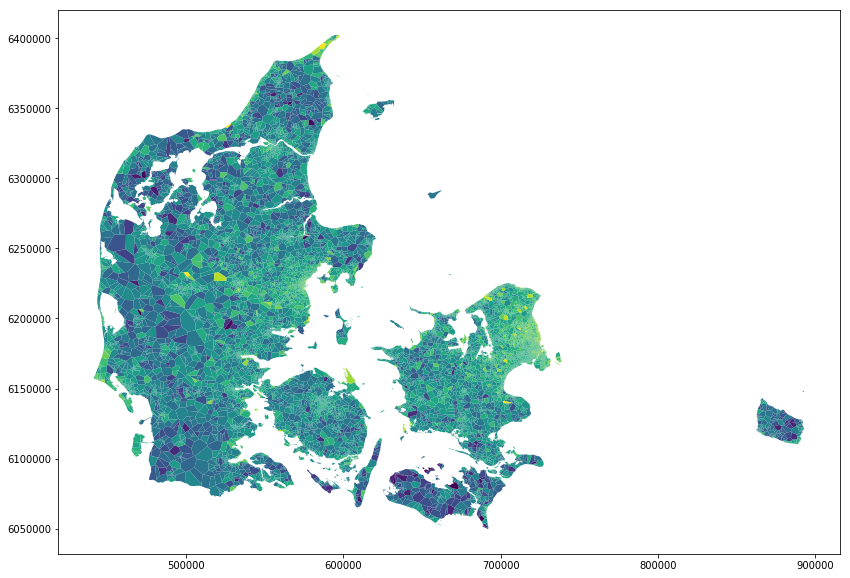

In [269]:
f_price_pointcloud

## Why spatial interpolation?

- Often we are interested in 
    - Data for neighborhoods not just points
    - Having measure available everywhere

- Spatial data is often sparse and pointwise    
    - What about areas in between?
    - Which points to use?


## Defining spatial interpolation

The nearest neighbor method

- Find the k nearest points
    - Regression: Take mean of k-nearest
    - Classification: Take mode of k-nearest

- The measurement space can be physical e.g. surface distance i 2d 
- Machine learning model 
    - non-parametric approach
    - requires normalization (e.g. L2)
    - be aware of high dimensional space

## Defining spatial interpolation (2)

Parameters that can be specified

- K: max number of neighbors
- Radius: maximum distance 
- Weight:
    - 'uniform' (default) ~ unweighted by distance
    - 'distance' ~ linear inverse distance weighting (IDW)
    - custom: quadratic IDW etc.

# Summary

We have learned about
- Spatial shapes and coordinate systems
- Perform operations on single shapes and collections of shapes
- Make interactive maps
- Interpolate spatial data

# Assignments / projects
Groups: 
- at most 3
- we recommend meeting new people :)

Data for projects:
- you should brainstorm yourself
- we have seen:
    - traffic
    - house price etc.
    - wikipedia  

# Further topics
- Spatial identification strategies
- Spatial autocorrelation
- Interpolation with `kriging`: assesing uncertainty